# Correlations among time series

This notebook examines the correlation between time series.

In [1]:
import sys
sys.path.append('../TimeSeries/')

import time_series as ts
import numpy as np
import matplotlib.pyplot as plt

Load a few ENTSO-E models:

In [2]:
CH_model = ts.import_model('../TimeSeries/models/entsoe_load_CH_2015_2023.npz')
DE_model = ts.import_model('../TimeSeries/models/entsoe_load_DE_2015_2023.npz')
FR_model = ts.import_model('../TimeSeries/models/entsoe_load_FR_2015_2023.npz')

## Definitions

Suppose that we have $N$ time series with $T$ time steps each, which we denote by $f_t^n$ with $t = 1, \ldots, T$ and $n = 1, \ldots, N$.

We also denote with $g_u^n$ the Fourier transform of each of the $N$ series with respect to time. There are also $T$ real components in each Fourier series ($u = 1, \ldots, T$).
Since this is a linear transformation, there exists an $T \times T$ matrix $A$ such that
$$f_t^n = \sum_{u=1}^T A_{t,u} g_u^n$$

The $g_u^n$ follow a multivariate normal distribution with mean
$$\widetilde{\mu}_u = \frac{1}{N} \sum_{n = 1}^N g_u^n$$
and covariance
$$\widetilde{\sigma}_{uv} = \frac{1}{N} \sum_{n = 1}^N g_u^n g_v^n - \widetilde{\mu}_u \widetilde{\mu}_v$$
$\widetilde{\mu}$ and $\widetilde{\sigma}$ are fixed by the model.

Here we create a sample with $N = 1000$:

In [3]:
CH_series = ts.generate_time_series(CH_model, 1000)
DE_series = ts.generate_time_series(DE_model, 1000)
FR_series = ts.generate_time_series(FR_model, 1000)

## Average characteristics of the time series

The mean value $\mu$ of the time series is the inverse Fourier transform of $\widetilde{\mu}$:
$$\mu_t = \frac{1}{N} \sum_{n=1}^N f_t^n = \sum_{u=1}^T A_{t,u} \widetilde{\mu}_u$$

In [4]:
CH_mu = ts.get_mu(CH_model)
DE_mu = ts.get_mu(DE_model)
FR_mu = ts.get_mu(FR_model)

With $N = 1000$, the difference between the statistical average and the model is below the percent level:

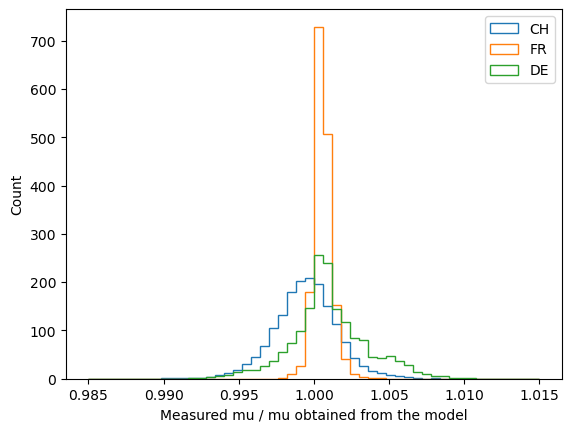

In [5]:
plt.hist(CH_series.mean(axis = 0) / CH_mu,
         range=(0.985, 1.015), bins=50, histtype='step', density=True, label='CH')
plt.hist(DE_series.mean(axis = 0) / DE_mu, 
         range=(0.985, 1.015), bins=50, histtype='step', density=True, label='FR')
plt.hist(FR_series.mean(axis = 0) / FR_mu, 
         range=(0.985, 1.015), bins=50, histtype='step', density=True, label='DE')
plt.legend()
plt.xlabel('Measured mu / mu obtained from the model')
plt.ylabel('Count')
plt.show()

Similarly, the covariance $\sigma$ of the time series is the Fourier transform of $\widetilde{\sigma}$ with respect to both indices:
$$
\sigma_{tt'} = \frac{1}{N} \sum_{n=1}^N f_t^n f_{t'}^n - \frac{1}{N^2} \sum_{n = 1}^N f_t^n \sum_{n' = 1}^N f_{t'}^{n'}
= \sum_{u=1}^T \sum_{v=1}^T A_{t,u} A_{t', v} \widetilde{\sigma}_{uv}
$$

In [6]:
CH_sigma = ts.get_sigma(CH_model)
FR_sigma = ts.get_sigma(FR_model)

Note that extracting the covariance matrix is memory-intensive, so we do not attempt to do it for the German model with 4 times as many time steps.

In [7]:
CH_sigma_measured = np.cov(CH_series, rowvar=False, bias=True)
FR_sigma_measured = np.cov(FR_series, rowvar=False, bias=True)

Because of the simplification that takes place in the model (covariances below a certain threshold are discarded), the measured covariance can differ a bit from the model's prediction:

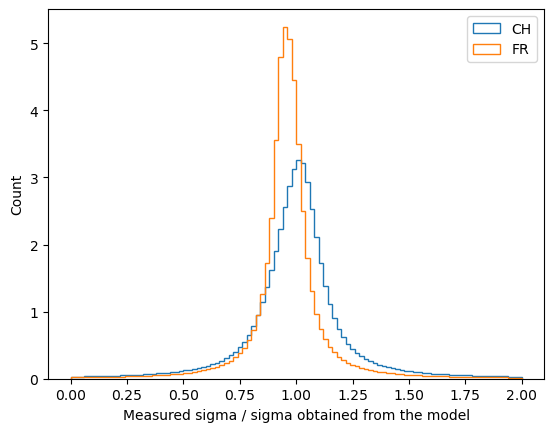

In [8]:
CH_sigma_ratio = CH_sigma_measured / CH_sigma
FR_sigma_ratio = FR_sigma_measured / FR_sigma

plt.hist(CH_sigma_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='CH')
plt.hist(FR_sigma_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='FR')
plt.xlabel('Measured sigma / sigma obtained from the model')
plt.ylabel('Count')
plt.legend()
plt.show()

However, the mean value is quite accurate:

In [9]:
CH_sigma_measured.mean() / CH_sigma.mean(), FR_sigma_measured.mean() / FR_sigma.mean()

(1.097498676718932, 0.9364730292766631)

The accuracy is better when considering only the variance (the diagonal of the covariance matrix):

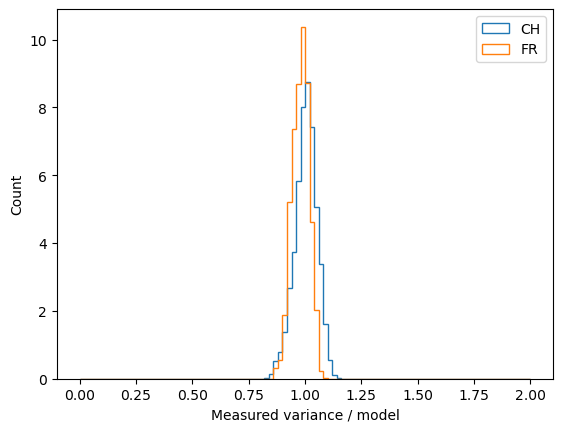

In [10]:
CH_sigma_diagonal_ratio = CH_sigma_measured.diagonal() / CH_sigma.diagonal()
FR_sigma_diagonal_ratio = FR_sigma_measured.diagonal() / FR_sigma.diagonal()

plt.hist(CH_sigma_diagonal_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='CH')
plt.hist(FR_sigma_diagonal_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='FR')
plt.xlabel('Measured variance / model')
plt.ylabel('Count')
plt.legend()
plt.show()

In [11]:
CH_sigma_measured.diagonal().mean() / CH_sigma.diagonal().mean()

1.0023467203938232

In [12]:
FR_sigma_measured.diagonal().mean() / FR_sigma.diagonal().mean()

0.9862580939394373

## Covariance between time series

The covariance between distinct time series is defined as:
$$\text{cov}_T(f^n, f^{n'}) = \frac{1}{T} \sum_{t=1}^T f_t^n f_t^{n'} - \frac{1}{T^2} \sum_{t=1}^T f_t^n \sum_{t'=1}^T f_{t'}^{n'}$$

In [13]:
def covariance_coefficients(time_series):
    covariance_matrix = np.cov(time_series, bias=True)
    upper_triangular_indices = np.triu_indices(covariance_matrix.shape[0], k=1)
    return covariance_matrix[upper_triangular_indices]

In [14]:
CH_cov_measured = covariance_coefficients(CH_series)
DE_cov_measured = covariance_coefficients(DE_series)
FR_cov_measured = covariance_coefficients(FR_series)

On average, the covariance is equal to the variance of $\mu$:
$$\overline{\text{cov}_T(f)} = \frac{1}{N^2} \sum_{n = 1}^N \sum_{n' = 1}^N \text{cov}_T(f^n, f^{n'})
= \frac{1}{T} \sum_{t=1}^T \mu_t^2 - \left( \frac{1}{T} \sum_{t=1}^T \mu_t \right)^2
= \text{var}_T(\mu)$$


This numbers agree very precisely with the average covariance measured from $N = 1000$ series: 

In [15]:
CH_mu_var = np.var(CH_mu)
DE_mu_var = np.var(DE_mu)
FR_mu_var = np.var(FR_mu)
CH_mu_var, DE_mu_var, FR_mu_var

(804346.1727001992, 90939014.92552942, 113868690.80642562)

In [16]:
CH_cov_measured.mean() / CH_mu_var, DE_cov_measured.mean() / DE_mu_var, FR_cov_measured.mean() / FR_mu_var

(1.0012074122854504, 1.000776422845957, 1.0010378268212587)

Note that the average covariance does not depend on $\sigma$: we can scale $\sigma$ over a large range of values without getting any difference:

In [17]:
std_scaling_values = np.exp(np.array(range(-20,21)) / 10)

In [18]:
CH_cov_scaling = [covariance_coefficients(ts.generate_time_series(CH_model, 100, std_scaling=std_scaling)).mean()
                  for std_scaling in std_scaling_values]
DE_cov_scaling = [covariance_coefficients(ts.generate_time_series(DE_model, 100, std_scaling=std_scaling)).mean()
                  for std_scaling in std_scaling_values]
FR_cov_scaling = [covariance_coefficients(ts.generate_time_series(FR_model, 100, std_scaling=std_scaling)).mean()
                  for std_scaling in std_scaling_values]

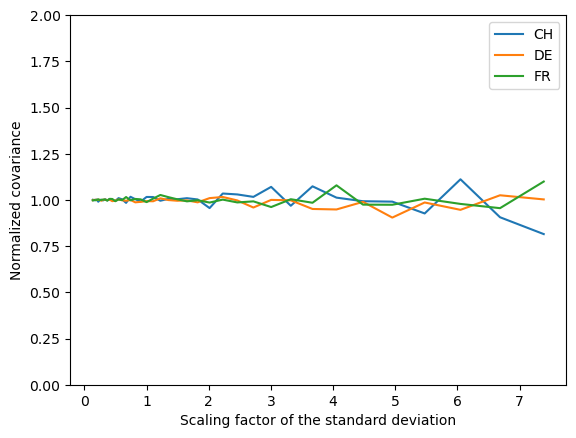

In [19]:
plt.plot(std_scaling_values, CH_cov_scaling / CH_mu_var, label='CH')
plt.plot(std_scaling_values, DE_cov_scaling / DE_mu_var, label='DE')
plt.plot(std_scaling_values, FR_cov_scaling / FR_mu_var, label='FR')
plt.ylim(0, 2)
plt.xlabel('Scaling factor of the standard deviation')
plt.ylabel('Normalized covariance')
plt.legend()
plt.show()

Since $T$ is a relatively large number, the covariance between series is actually pretty close to being constant:

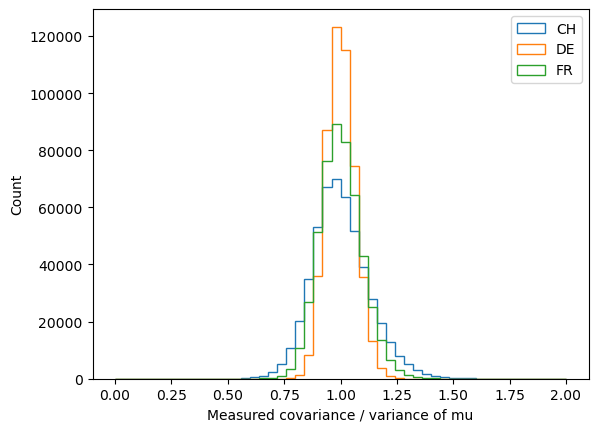

In [20]:
plt.hist(CH_cov_measured / CH_mu_var, histtype='step', label='CH', range=(0,2), bins=50)
plt.hist(DE_cov_measured / DE_mu_var, histtype='step', label='DE', range=(0,2), bins=50)
plt.hist(FR_cov_measured / FR_mu_var, histtype='step', label='FR', range=(0,2), bins=50)
plt.xlabel('Measured covariance / variance of mu')
plt.ylabel('Count')
plt.legend()
plt.show()

## Variance of a time series

The variance of an individual time series is defined by
$$\text{var}_T(f^n) = \frac{1}{T} \sum_{t=1}^T (f_t^n)^2 - \left( \frac{1}{T} \sum_{t=1}^T f_t^n \right)^2$$

When averaging over multiple series, this becomes
$$
\overline{\text{var}_T(f)} = \frac{1}{N} \sum_{n=1}^N \text{var}_T(f^n)
= \frac{1}{T} \sum_{t=1}^T \left( \frac{1}{N} \sum_{n=1}^N (f_t^n)^2 \right) -
\frac{1}{T^2} \sum_{t=1}^T \sum_{t'=1}^T \left(\frac{1}{N} \sum_{n=1}^N f_t^n f_{t'}^n \right)
$$

Using the definition of $\mu$ and $\sigma$, we can write
$$ \frac{1}{N} \sum_{n=1}^N f_t^n f_{t'}^n = \sigma_{tt'} + \mu_t \mu_{t'}$$
and therefore
$$
\overline{\text{var}_T(f)} = \frac{1}{T} \sum_{t=1}^T (\sigma_{tt} + \mu_t^2) -
\frac{1}{T^2} \sum_{t=1}^T \sum_{t'=1}^T (\sigma_{tt'} + \mu_t \mu_{t'})
$$
This is the variance of $\mu$ plus the variance of $\sigma$
$$\overline{\text{var}_T(f)} = \text{var}_T(\mu) + \text{var}_T(\sigma)$$
where $\text{var}_T(\mu)$ was defined above (it is equal to the average covariance $\overline{\text{cov}_T(f)}$) and
$$\text{var}_T(\sigma) = \frac{1}{T} \sum_{t=1}^T \sigma_{tt} - \frac{1}{T^2} \sum_{t=1}^T \sum_{t'=1}^T \sigma_{tt'}$$

In [21]:
CH_sigma_var = ts.get_sigma_variance(CH_model)
DE_sigma_var = ts.get_sigma_variance(DE_model)
FR_sigma_var = ts.get_sigma_variance(FR_model)

In [22]:
CH_var = CH_mu_var + CH_sigma_var
DE_var = DE_mu_var + DE_sigma_var
FR_var = FR_mu_var + FR_sigma_var

In [23]:
CH_var_measured = CH_series.var(axis = 1)
DE_var_measured = DE_series.var(axis = 1)
FR_var_measured = FR_series.var(axis = 1)

In [24]:
CH_var_measured.mean() / CH_var, DE_var_measured.mean() / DE_var, FR_var_measured.mean() / FR_var

(0.999594375279924, 1.0000362122304884, 1.0009005046502666)

In this case the variance depends on $\sigma$: if we scale $\sigma \to \lambda^2 \sigma$, then the variance obeys
$$\overline{\text{var}_T(f)} = \text{var}_T(\mu) + \lambda^2 \text{var}_T(\sigma)$$

In [25]:
CH_var_scaling = [ts.generate_time_series(CH_model, 100, std_scaling=std_scaling).var(axis = 1).mean()
                  for std_scaling in std_scaling_values]
DE_var_scaling = [ts.generate_time_series(DE_model, 100, std_scaling=std_scaling).var(axis = 1).mean()
                  for std_scaling in std_scaling_values]
FR_var_scaling = [ts.generate_time_series(FR_model, 100, std_scaling=std_scaling).var(axis = 1).mean()
                  for std_scaling in std_scaling_values]

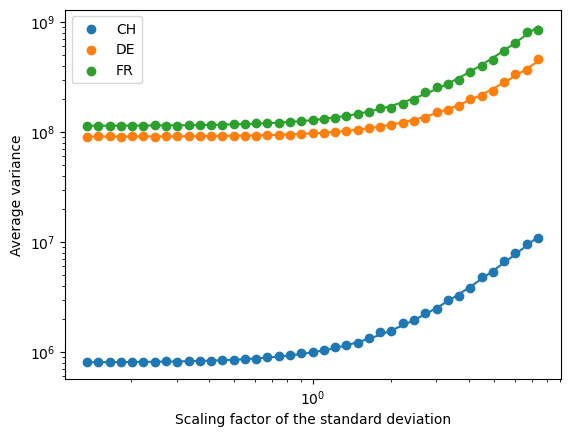

In [26]:
plt.plot(std_scaling_values, CH_mu_var + CH_sigma_var * std_scaling_values**2)
plt.plot(std_scaling_values, DE_mu_var + DE_sigma_var * std_scaling_values**2)
plt.plot(std_scaling_values, FR_mu_var + FR_sigma_var * std_scaling_values**2)
plt.scatter(std_scaling_values, CH_var_scaling, label='CH')
plt.scatter(std_scaling_values, DE_var_scaling, label='DE')
plt.scatter(std_scaling_values, FR_var_scaling, label='FR')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Scaling factor of the standard deviation')
plt.ylabel('Average variance')
plt.legend()
plt.show()

Like the covariance, the variance is more or less constant

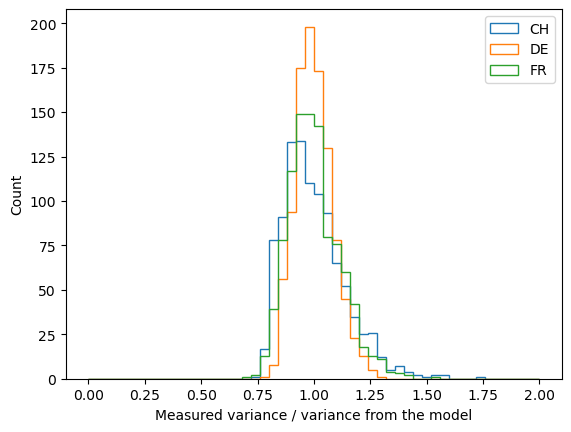

In [27]:
plt.hist(CH_var_measured / CH_var, histtype='step', label='CH', range=(0,2), bins=50)
plt.hist(DE_var_measured / DE_var, histtype='step', label='DE', range=(0,2), bins=50)
plt.hist(FR_var_measured / FR_var, histtype='step', label='FR', range=(0,2), bins=50)
plt.xlabel('Measured variance / variance from the model')
plt.ylabel('Count')
plt.legend()
plt.show()

## Correlation between time series

The correlation between two times series is defined by
$$\rho^{n,n'} = \frac{\text{cov}_T(f^n, f^{n'})}{\sqrt{\text{var}_T(f^n) \text{var}_T(f^{n'})}}$$

The distribution of correlations differs between countries. This is due to the fact that the variance of the input data is different: larger countries have more 'averaged' load profiles, the variance is smaller, and therefore the correlation between synthetic series is larger.

In [28]:
CH_correlations = ts.compute_pairwise_correlations(CH_series)
DE_correlations = ts.compute_pairwise_correlations(DE_series)
FR_correlations = ts.compute_pairwise_correlations(FR_series)

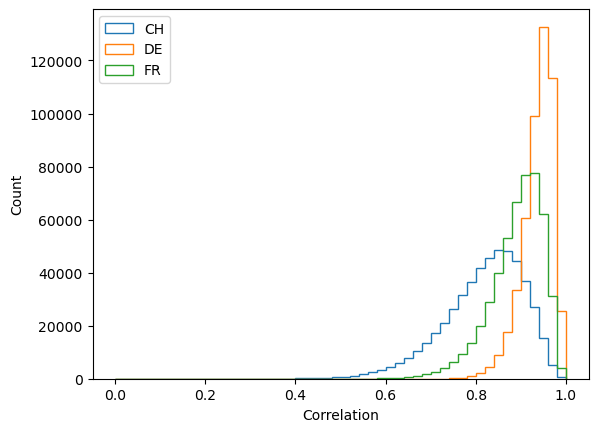

In [29]:
plt.hist(CH_correlations, range=(0,1), bins=50, histtype='step', label='CH')
plt.hist(DE_correlations, range=(0,1), bins=50, histtype='step', label='DE')
plt.hist(FR_correlations, range=(0,1), bins=50, histtype='step', label='FR')
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.show()

Since both the variance and the covariance of time series are pretty much constant, the average correlation between distinct series can be approximated as
$$
\overline{\rho} = \frac{1}{N^2} \sum_{n = 1}^N \sum_{n' = 1}^N \frac{\text{cov}_T(f^n, f^{n'})}{\sqrt{\text{var}_T(f^n) \text{var}_T(f^{n'})}}
\approx \frac{\overline{\text{cov}_T(f)}}{\overline{\text{var}_T(f)}}
$$
From what we found above, this is
$$
\overline{\rho} \approx \frac{\text{var}_T(\mu)}{\text{var}_T(\mu) + \text{var}_T(\sigma)} 
= \frac{1}{1 + \kappa}
$$
where 
$$\kappa = \frac{\text{var}_T(\sigma)}{\text{var}_T(\mu)}$$

In [30]:
CH_k = CH_sigma_var / CH_mu_var
DE_k = DE_sigma_var / DE_mu_var
FR_k = FR_sigma_var / FR_mu_var
CH_k, DE_k, FR_k

(0.23649018231076488, 0.07033737232239311, 0.12888215277134663)

In [31]:
CH_correlations.mean() * (1 + CH_k), DE_correlations.mean() * (1 + DE_k), FR_correlations.mean() * (1 + FR_k)

(1.0092770805126048, 1.0028792166785807, 1.0045596335748455)

This give a simple rule on how correlations scale if we scale $\sigma \to \lambda^2 \sigma$:
$$\overline{\rho} = \frac{1}{1 + \lambda^2 \kappa}$$

In [32]:
CH_correlations_scaling = [ts.compute_pairwise_correlations(ts.generate_time_series(CH_model, 100, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]
DE_correlations_scaling = [ts.compute_pairwise_correlations(ts.generate_time_series(DE_model, 100, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]
FR_correlations_scaling = [ts.compute_pairwise_correlations(ts.generate_time_series(FR_model, 100, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]

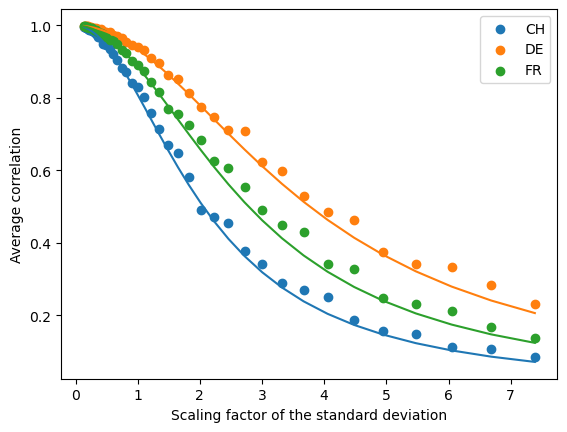

In [33]:
plt.plot(std_scaling_values, 1 / (1 + CH_k * std_scaling_values**2))
plt.plot(std_scaling_values, 1 / (1 + DE_k * std_scaling_values**2))
plt.plot(std_scaling_values, 1 / (1 + FR_k * std_scaling_values**2))
plt.scatter(std_scaling_values, CH_correlations_scaling, label='CH')
plt.scatter(std_scaling_values, DE_correlations_scaling, label='DE')
plt.scatter(std_scaling_values, FR_correlations_scaling, label='FR')
plt.xlabel('Scaling factor of the standard deviation')
plt.ylabel('Average correlation')
plt.legend()
plt.show()

This relation can be used to obtain time series with a given correlation by adjusting the standard deviation of the model
$$\lambda = \sqrt{\kappa^{-1} \left(\langle \rho \rangle^{-1} - 1 \right)}$$

In [34]:
CH_std_scaling = ts.get_optimal_std_scaling(CH_model, 0.75)
DE_std_scaling = ts.get_optimal_std_scaling(DE_model, 0.75)
FR_std_scaling = ts.get_optimal_std_scaling(FR_model, 0.75)
CH_std_scaling, DE_std_scaling, FR_std_scaling

(1.1872244024402863, 2.1769392149434483, 1.6082108277517058)

In [35]:
CH_series_adjusted = ts.generate_time_series(CH_model, 1000, std_scaling=CH_std_scaling)
DE_series_adjusted = ts.generate_time_series(DE_model, 1000, std_scaling=DE_std_scaling)
FR_series_adjusted = ts.generate_time_series(FR_model, 1000, std_scaling=FR_std_scaling)

In [36]:
CH_correlations_adjusted = ts.compute_pairwise_correlations(CH_series_adjusted)
DE_correlations_adjusted = ts.compute_pairwise_correlations(DE_series_adjusted)
FR_correlations_adjusted = ts.compute_pairwise_correlations(FR_series_adjusted)

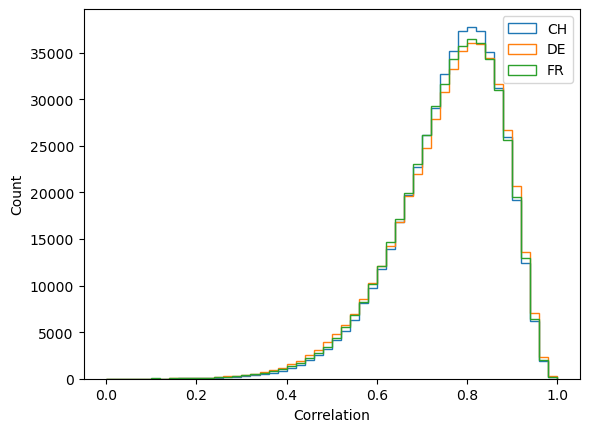

In [37]:
plt.hist(CH_correlations_adjusted, range=(0,1), bins=50, histtype='step', label='CH')
plt.hist(DE_correlations_adjusted, range=(0,1), bins=50, histtype='step', label='DE')
plt.hist(FR_correlations_adjusted, range=(0,1), bins=50, histtype='step', label='FR')
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.legend()
plt.show()